# **Cài đặt thư viện Pytorch**

In [ ]:
!pip install timm torchvision

# **Tải dữ liệu về**

In [18]:
!curl -L "https://app.roboflow.com/ds/YPUYOwgVZ5?key=MYAPIKEY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   3035      0 --:--:-- --:--:-- --:--:--  3040
100  151M  100  151M    0     0  22.4M      0  0:00:06  0:00:06 --:--:-- 30.5M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
   creating: test/ANP3.2/
 extracting: test/ANP3.2/_102_jpg.rf.03bf123dcba2e9182492c6d2c4176c5e.jpg  
 extracting: test/ANP3.2/_107_jpg.rf.ae795c8d3b5344110ab994cf4fa85115.jpg  
 extracting: test/ANP3.2/_10_jpg.rf.4db435efca2e718ca854efa525ac81f5.jpg  
 extracting: test/ANP3.2/_110_jpg.rf.e911e91373036f6443ad2ffd0b4aaca2.jpg  
 extracting: test/ANP3.2/_114_jpg.rf.e722c0a6ea3d076853cbd8420f9d0d85.jpg  
 extracting: test/ANP3.2/_115_jpg.rf.4e22e833c05291a5afc28f1b77656a28.jpg  
 extracting: test/ANP3.2/_116_jpg.rf.68501c4d5328a949d1fb63d7f6fe01b2.jpg  
 extracti

# **Cấu hình dữ liệu**

In [49]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader


# Tiền xử lý ảnh
image_size = 300

train_transforms = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load dataset từ thư mục
train_dataset = datasets.ImageFolder(root="/kaggle/working/train", transform=train_transforms)
val_dataset = datasets.ImageFolder(root="/kaggle/working/valid", transform=transform)
test_dataset = datasets.ImageFolder(root="/kaggle/working/test", transform=transform)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Lấy số lượng class
num_classes = len(train_dataset.classes)
print(f"Số lớp trong dataset: {num_classes}")


Số lớp trong dataset: 8


# **Tạo model và tìm learning rate**

  0%|          | 0/421 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.16E-04


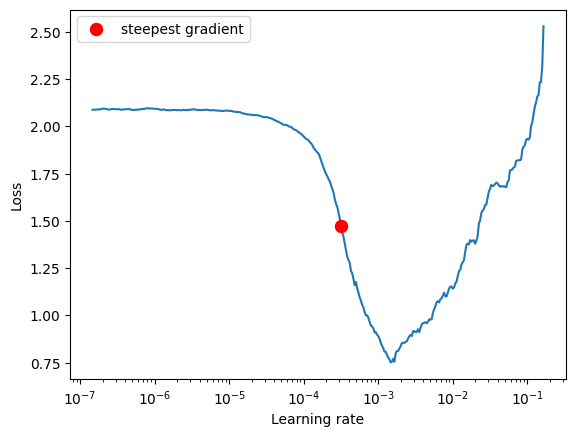

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.00031622776601683794)

In [51]:
!pip install torch_lr_finder
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import timm


# Load EfficientNet-B0 (hoặc B3 nếu có GPU mạnh)
model = timm.create_model("efficientnet_b3", pretrained=True)

# Sửa lại fully connected layer cho số class của dataset
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

# Chuyển model về GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model.train()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-7)

lr_finder = LRFinder(model, optimizer, criterion, device=device)

lr_finder.range_test(train_loader, end_lr=1, num_iter=len(train_loader))

lr_finder.plot()

# **Cấu hình tham số và huấn luyện mô hình**

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.16e-04, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

# Số epoch
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss_total = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_total / len(val_loader)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Cập nhật learning rate scheduler
    scheduler.step(avg_val_loss)

Epoch 1, Loss: 4.3460, Val Loss: 1.6594, Val Acc: 36.63%
Epoch 2, Loss: 1.3970, Val Loss: 1.2472, Val Acc: 52.01%
Epoch 3, Loss: 1.2104, Val Loss: 1.1415, Val Acc: 58.13%
Epoch 4, Loss: 1.0842, Val Loss: 1.0689, Val Acc: 63.27%
Epoch 5, Loss: 0.9286, Val Loss: 0.8310, Val Acc: 70.58%
Epoch 6, Loss: 0.7765, Val Loss: 0.6869, Val Acc: 75.10%
Epoch 7, Loss: 0.6544, Val Loss: 0.5983, Val Acc: 77.93%
Epoch 8, Loss: 0.5647, Val Loss: 0.5326, Val Acc: 82.41%
Epoch 9, Loss: 0.5018, Val Loss: 0.4274, Val Acc: 84.83%
Epoch 10, Loss: 0.4458, Val Loss: 0.4600, Val Acc: 83.44%
Epoch 11, Loss: 0.3955, Val Loss: 0.3613, Val Acc: 86.99%
Epoch 12, Loss: 0.3514, Val Loss: 0.5220, Val Acc: 81.94%
Epoch 13, Loss: 0.3330, Val Loss: 0.3921, Val Acc: 87.14%
Epoch 14, Loss: 0.2973, Val Loss: 0.3632, Val Acc: 88.32%
Epoch 15, Loss: 0.2742, Val Loss: 0.4378, Val Acc: 85.85%
Epoch 16, Loss: 0.2529, Val Loss: 0.2982, Val Acc: 89.87%
Epoch 17, Loss: 0.2449, Val Loss: 0.3447, Val Acc: 87.55%
Epoch 18, Loss: 0.2222,

# **Đánh giá mô hình**

Số lượng class: 8
Tên các class: ['ANP3.2', 'F5.54', 'F5.62', 'G13-II', 'G17-III', 'G18-I', 'G3-III', 'G7-III']
Test Loss: 0.2681, Test Accuracy: 0.9064

Classification Report:
              precision    recall  f1-score   support

      ANP3.2       0.95      0.92      0.93       187
       F5.54       0.99      1.00      1.00       130
       F5.62       0.89      0.91      0.90       173
      G13-II       0.92      0.93      0.93       363
     G17-III       0.99      0.99      0.99       246
       G18-I       0.87      0.83      0.85       282
      G3-III       0.83      0.97      0.89       319
      G7-III       0.90      0.72      0.80       234

    accuracy                           0.91      1934
   macro avg       0.92      0.91      0.91      1934
weighted avg       0.91      0.91      0.91      1934



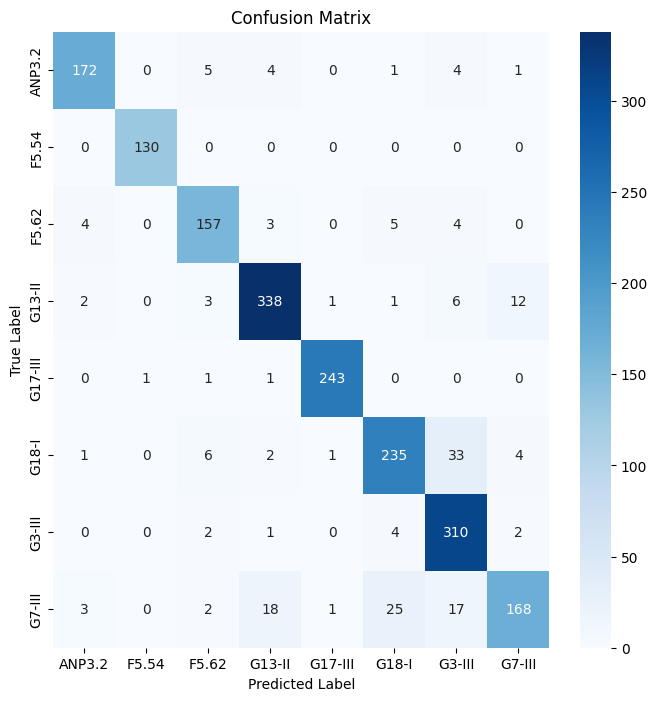

In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chuẩn bị dữ liệu test (đảm bảo đường dẫn chính xác)
data_dir = '/kaggle/working/'  # Thay đường dẫn này bằng đường dẫn đến thư mục gốc của dữ liệu
test_dir = os.path.join(data_dir, 'test')

# Định nghĩa transformations cho tập test
transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tạo dataset test
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Tạo dataloader test
batch_size = 32

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Số lượng class và tên class
num_classes = len(test_dataset.classes)
class_names = test_dataset.classes
print(f"Số lượng class: {num_classes}")
print(f"Tên các class: {class_names}")

# 2. Sử dụng lại mô hình đã huấn luyện (biến 'model' từ cell trước)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Chuyển mô hình sang chế độ đánh giá

# 3. Thực hiện đánh giá trên tập test
all_labels = []
all_predictions = []
test_loss = 0.0
correct_predictions = 0
total_samples = 0
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = test_loss / total_samples
test_accuracy = correct_predictions / total_samples
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("/kaggle/working/efficient_matrix.png")
plt.show()

# **Lưu và tải mô hình**

In [ ]:
from google.colab import files
import shutil

save_path = '/kaggle/working/efficientNet.pth' 
torch.save(model, save_path)
print(f"Mô hình đã được lưu tại: {save_path}")

shutil.make_archive("/kaggle/working/efficientNet.pth","zip","/kaggle/working/efficientNet.pth")
files.download("/kaggle/working/efficientNet.pth.zip")